In [131]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller

# Connect to SQL database
import sqlite3
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()

In [282]:
# Import tables

# df_bixi = pd.read_sql_query("SELECT * FROM bixi", connex)
df_weather = pd.read_sql_query("SELECT * FROM weather", connex)
df_holiday = pd.read_sql_query("SELECT * FROM holiday", connex)
# df_stations = pd.read_sql_query("SELECT * FROM stations",connex)
cur.close()

In [10]:
def describe_df(df):
    print(f'{df.head(2)}\n')
    print(f'{df.info()}\n')
    print(f'shape: {df.shape} \n')
    print(f'Number of null values: \n{df.isnull().sum()}\n')
    print(f'Number of duplicate rows: {df.duplicated().sum()}')

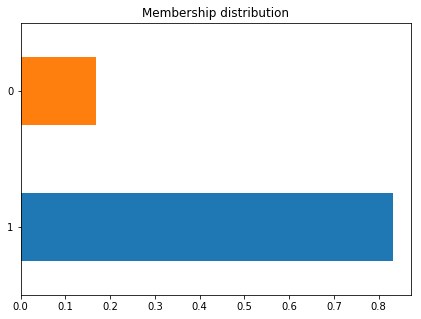

In [12]:
# Membership distribution
df_bixi.is_member.value_counts(normalize = True).plot.barh(title = 'Membership distribution', figsize = (7,5))

1 - Extract from Start_date and End_date date, hour, minute. Add day of the week as feature

In [133]:
# Extract date, hour, minute and day of the week for start date

df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['start_datetime'] = df_bixi['start_date']
df_bixi['start_month'] = df_bixi['start_date'].dt.month
df_bixi['start_hour'] = df_bixi['start_date'].dt.hour
df_bixi['start_weekday'] = df_bixi['start_date'].dt.dayofweek
df_bixi['start_date'] = df_bixi['start_date'].dt.date

# Repeat process for End timestamp

# df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])
# df_bixi['end_datetime'] = df_bixi['end_date']
# df_bixi['end_month'] = df_bixi['end_date'].dt.month
# df_bixi['end_hour'] = df_bixi['end_date'].dt.hour
# df_bixi['end_weekday'] = df_bixi['end_date'].dt.dayofweek
# df_bixi['end_date'] = df_bixi['end_date'].dt.date

In [134]:
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 4, 10)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 11, 15)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['duration_sec'] > 120] # Retaining trips longer than 2 minutes
# df_bixi = df_bixi[df_bixi['start_weekday'] < 5] # Retaining trips taken during weekdays
df_bixi = df_bixi.reset_index().drop(['index'], axis = 1) # Reset index

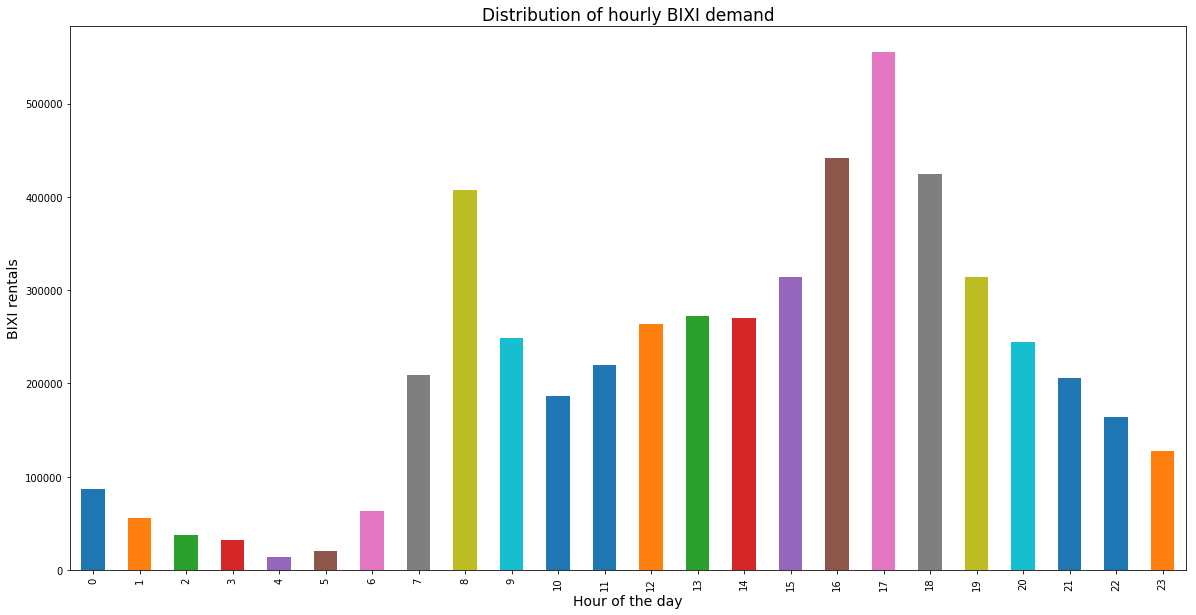

In [136]:
# Demand by hour (0 = From Midnight to 1AM)

grouped_hour = df_bixi.groupby(df_bixi['start_hour']).count().reset_index()
grouped_hour = grouped_hour[['start_hour','start_date']]
grouped_hour.rename(columns = {'start_date':'count'}, inplace = True)
ax_hour = grouped_hour.plot.bar(x = 'start_hour', y = 'count', figsize=(20,10))
ax_hour.set_xlabel('Hour of the day', fontsize=14)
ax_hour.set_ylabel('BIXI rentals', fontsize=14)
ax_hour.set_title("Distribution of hourly BIXI demand", fontsize=17)
ax_hour.get_legend().remove()

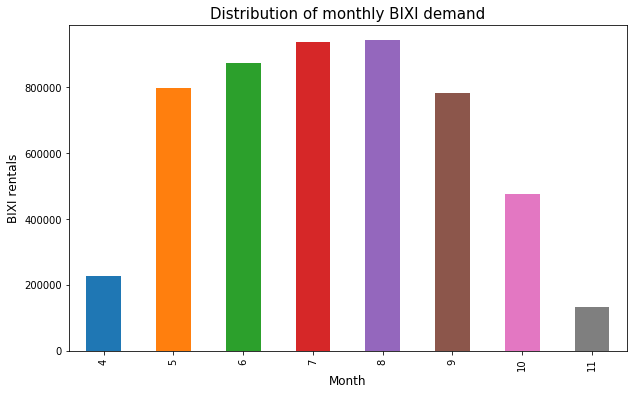

In [137]:
# Average Demand by month
grouped_month = df_bixi.groupby(df_bixi['start_month']).count().reset_index()
grouped_month = grouped_month[['start_month','start_date']]
grouped_month.rename(columns = {'start_date':'count'}, inplace = True)
ax_month = grouped_month.plot.bar(x = 'start_month', y = 'count', figsize=(10,6))
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('BIXI rentals', fontsize=12)
ax_month.set_title("Distribution of monthly BIXI demand", fontsize=15)
ax_month.get_legend().remove()

Text(0.5, 1.0, 'Distribution of BIXI demand by day of the week')

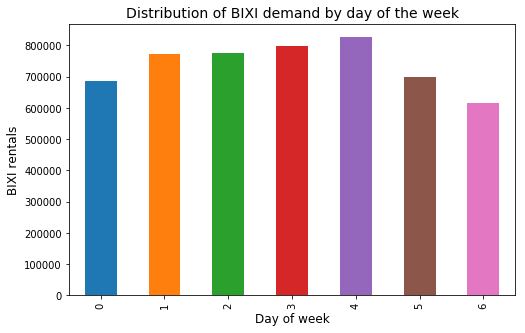

In [138]:
# Demand by day of the week (0 = Monday)

df_by_day = pd.DataFrame(df_bixi.groupby('start_weekday').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})
ax_day = df_by_day.reset_index().plot.bar(x = 'start_weekday', y = '# Bixi rentals', figsize=(8,5))
ax_day.get_legend().remove()
ax_day.set_xlabel("Day of week", fontsize=12)
ax_day.set_ylabel("BIXI rentals", fontsize=12)
ax_day.set_title("Distribution of BIXI demand by day of the week", fontsize=14)

In [139]:
# To group by date & hour - remove minute granularity
df_bixi['date_hour'] = df_bixi['start_datetime'].apply(lambda x: x.replace(minute=0))

In [20]:
def heat_withtime():
    scaler = MinMaxScaler()
    df_bixi_hm = df_bixi.rename({'start_station_code':'code'}, axis = 1).merge(df_stations)
    df_bixi_hm['count'] = 1
    
    df_hour_list = []
    for hour in list(range(0,24)):
        df = df_bixi_hm.loc[df_bixi_hm.start_hour == hour, ['latitude', 'longitude','count']]
        df = df.groupby(['latitude', 'longitude']).sum()
        df['count'] = scaler.fit_transform(df)
        df_hour_list.append(df.reset_index().values.tolist())

    mtl_coordinates = (45.527616, -73.589115)

    # create empty map
    m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
    HeatMapWithTime(df_hour_list, index = list(range(0,24)), radius = 15,
                    min_opacity= 0.5, max_opacity=1,
                    gradient={0.001: 'blue', 0.05: 'green', 0.1: 'orange', 0.5: 'red', 0.9: 'darkred'}).add_to(m)
    return m

In [21]:
heat_withtime()

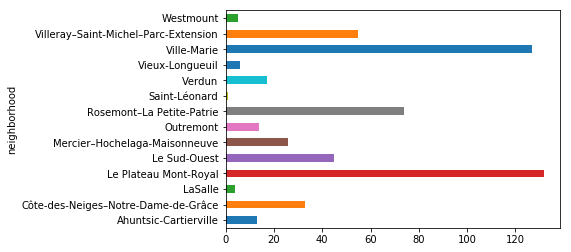

In [22]:
df_stations.groupby('neighborhood').count().code.plot.barh()

In [23]:
# Morning departures

df_morning = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_morning = df_morning[df_morning['start_hour'] <= 11]
df_morning = df_morning[df_morning['start_hour'] >= 5]

df_mcount = pd.DataFrame(df_morning.groupby('start_station_code').count().sort_values('start_date', ascending = False).start_date)
df_mcount = df_mcount.reset_index().rename({'start_station_code':'code', 'start_date': 'count'}, axis = 1)
df_mcount = df_mcount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr = df_mcount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_mcount.iterrows():
    folium.CircleMarker(location = [row[1]['latitude'],row[1]['longitude']],
                 popup = row[1]['location'],
                 radius = row[1]['count']/10000,
                 fill=True).add_to(m)
m.add_child(HeatMap(arr, radius=15))
m

In [140]:
df_bixi_byhour = df_bixi.set_index('date_hour').reset_index()
df_bixi_byhour = pd.DataFrame(df_bixi_byhour.groupby('date_hour').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})
df_bixi_byhour = df_bixi_byhour.asfreq('H')

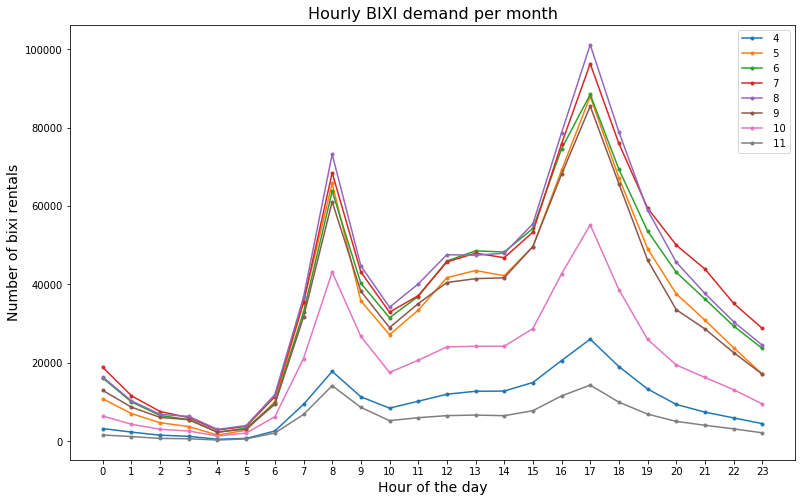

In [25]:
df_mth = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour.values),(df_bixi_byhour.index.month.values)]).sum().unstack()

ax_mth = df_mth.plot(figsize = (13,8),subplots = False, marker = '.')
ax_mth.set_xlabel('Hour of the day', size =14)
ax_mth.set_xticks(range(0,24))
ax_mth.set_ylabel('Number of bixi rentals',size =14)
ax_mth.set_title('Hourly BIXI demand per month', size =16)
handles, labels = ax_mth.get_legend_handles_labels()
labels_new = [label.strip('()').split(',')[1] for label in labels]
plt.legend(handles, labels_new)

Text(0, 0.5, 'Day of the week')

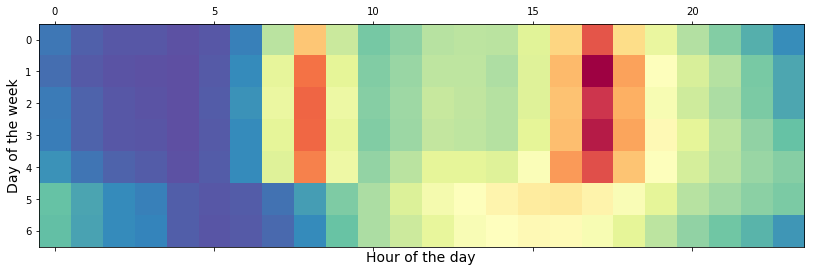

In [141]:
# Day of week usage vs hour of the day

df_day_hour = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour),(df_bixi_byhour.index.dayofweek.values)]).sum().unstack()
plt.matshow(df_day_hour.T, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.xlabel('Hour of the day', size = 14)
plt.ylabel('Day of the week', size = 14)


#### Weather

In [283]:
df_weather['date_hour'] = pd.to_datetime(df_weather['date_hour'])

In [284]:
df_weather.day_ind.replace({'N':0, 'D':1}, inplace = True)

In [285]:
df_weather.precip_hrly = df_weather.precip_hrly.apply(lambda x: 1 if x > 0 else 0)
df_weather.precip_total = df_weather.precip_total.apply(lambda x: 1 if x > 0 else 0)

In [286]:
# df_bixi.drop(['end_station_code','start_datetime','end_date'], axis =1, inplace =True)

In [287]:
df_member = df_bixi.groupby('date_hour').sum()['is_member'].reset_index()
df = df_bixi_byhour.merge(df_weather, on = 'date_hour', how = 'left').merge(df_member, on = 'date_hour', how = 'left')
df['casual'] = df['# Bixi rentals'] - df['is_member']

In [288]:
df.bfill(inplace= True) # missing some hourly weather data (~120 readings), complete with previous reading

In [291]:
df['is_weekend'] = df['date_hour'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: 1 if x >4 else 0)

In [292]:
df = df.set_index('date_hour')

In [293]:
df.head()

,# Bixi rentals,day_ind,feels_like,heat_index,precip_hrly,precip_total,humidity,temp,uv_desc,uv_index,wind_speed,condition,is_member,casual,is_weekend
date_hour,,,,,,,,,,,,,,,
2018-04-11 00:00:00,50,0.0,27.0,32.0,0.0,0.0,83.0,32.0,Low,0.0,6.0,Fair,41,9,0
2018-04-11 01:00:00,27,0.0,26.0,34.0,0.0,0.0,75.0,34.0,Low,0.0,10.0,Fair,17,10,0
2018-04-11 02:00:00,8,0.0,26.0,33.0,0.0,0.0,74.0,33.0,Low,0.0,8.0,Fair,8,0,0
2018-04-11 03:00:00,7,0.0,25.0,32.0,0.0,0.0,70.0,32.0,Low,0.0,8.0,Fair,7,0,0
2018-04-11 04:00:00,6,0.0,29.0,29.0,0.0,0.0,75.0,29.0,Low,0.0,2.0,Fair,6,0,0


> - To identify which exogenous variables (X) into SARIMAX, looking at the correlation with bike rentals is useful.
> - "Heat index", "feels like", "temp" seem to bring the same information as they are almost perfectly correlated. 
> - **Including** "temp" is appropriate as it is slightly more correlated with the number of rentals.
> - "UV index" and "humidity" are also correlated with the number of rentals and they will be **included** in the model.
> - Surprisingly, precipitation is not so correlated and will be **excluded** from SARIMAX.
> - Another interesting fact is that **casual** members' bike usage is more correlated with temperature, uv_index and whether it rained or not during their rental then **members**!

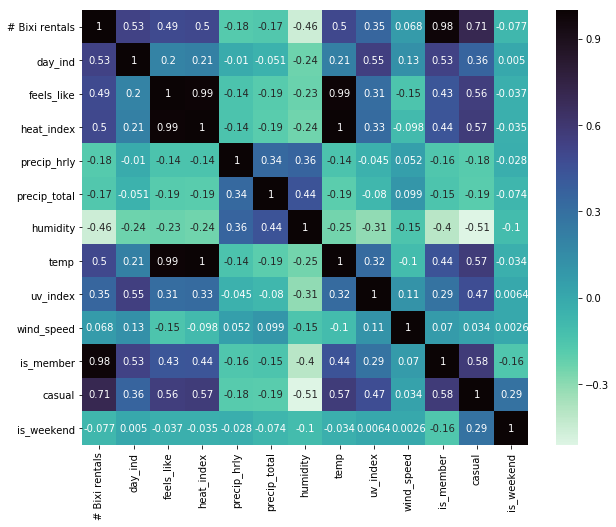

In [294]:
# To identify patterns in usage for casual vs members
# There is a slight difference in behaviour depending on the temperature, heat_index and feels like temperature

plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot = True, cmap ='mako_r')

### Time Series analysis

In [32]:
rolmean = df_bixi_byhour['04-2018'].rolling(window = 24, center = False).mean()
rolstd = df_bixi_byhour['04-2018'].rolling(window = 24, center = False).std()

In [280]:
fig = plt.figure(figsize=(18,10))
orig = plt.plot(df_bixi_byhour['04-2018'], color='teal',label='Original')
mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [275]:
df_bixi_byhour.plot(figsize=(23,8), c = 'teal', style = '.b')

In [278]:
# Timeseries plot by hour
plt.style.use('ggplot')
ax = df_bixi_byhour.plot(figsize=(23,8), c = 'teal')
ax.set_ylabel("BIXI rentals", fontsize=16)
ax.set_xlabel("Date: by hour", fontsize=16)
ax.set_title('Timeseries: Hourly BIXI demand from April to November', fontsize=16)
ax.legend(fontsize = 15)
plt.show()

### Decomposition + Base Model

In [38]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 18, 8

In [39]:
# Seasonality seems to be present as patterns seem to repeat every 7 days.
# It makes sense to compare the same day of the week at the same hour to remove seasonality.

def stationarity_check(df):

    rolmean = df.dropna().rolling(window = 24).mean()
    rolstd = df.rolling(window = 24, center = False).std()
    
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(df.dropna(), color='b',label='Original', alpha = 0.25)
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    decomp = seasonal_decompose(df.dropna(), model='additive', freq=24) # Repetition every week
    ax = decomp.plot()
    plt.show
    
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

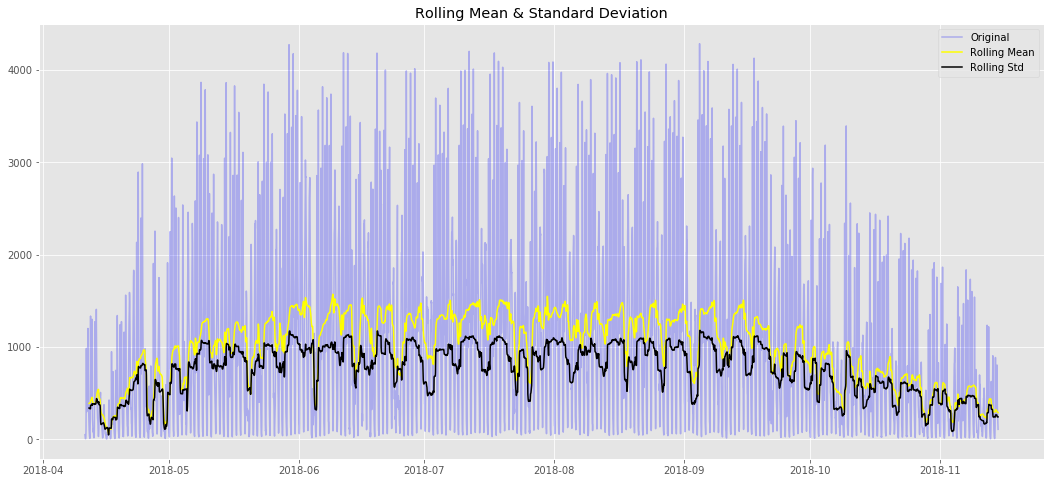

ADF Statistic: -5.605703
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


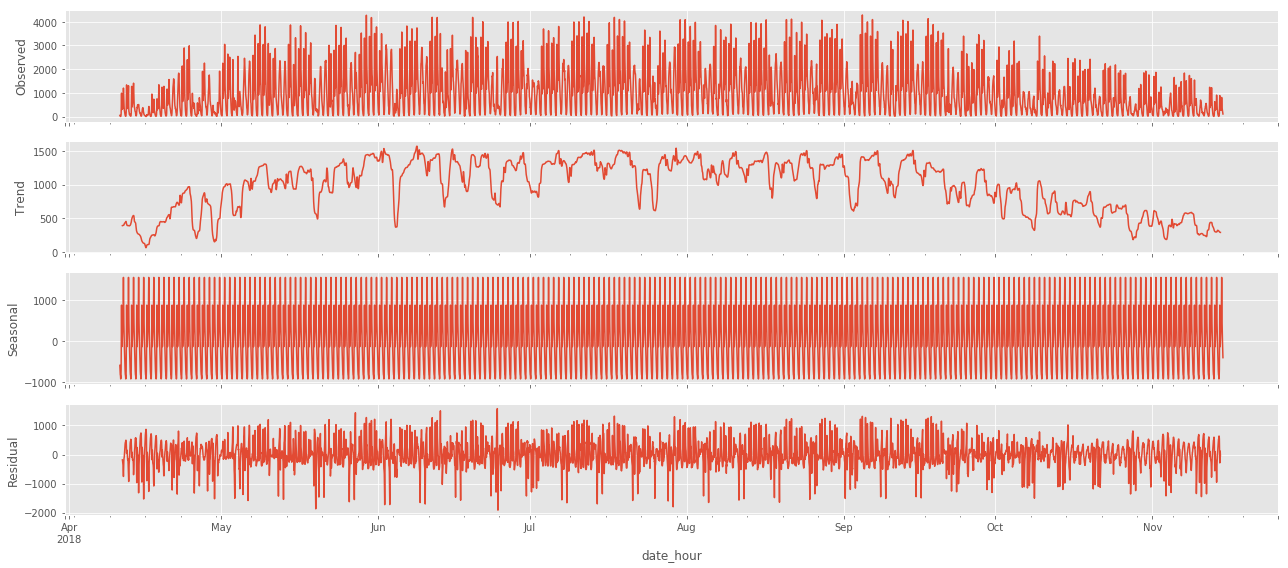

In [40]:
stationarity_check(df_bixi_byhour)

In [41]:
# decomp = seasonal_decompose(df_bixi_byhour,model='additive', freq=24*7)
# ax = decomp.plot()
# plt.show

<function matplotlib.pyplot.show(*args, **kw)>

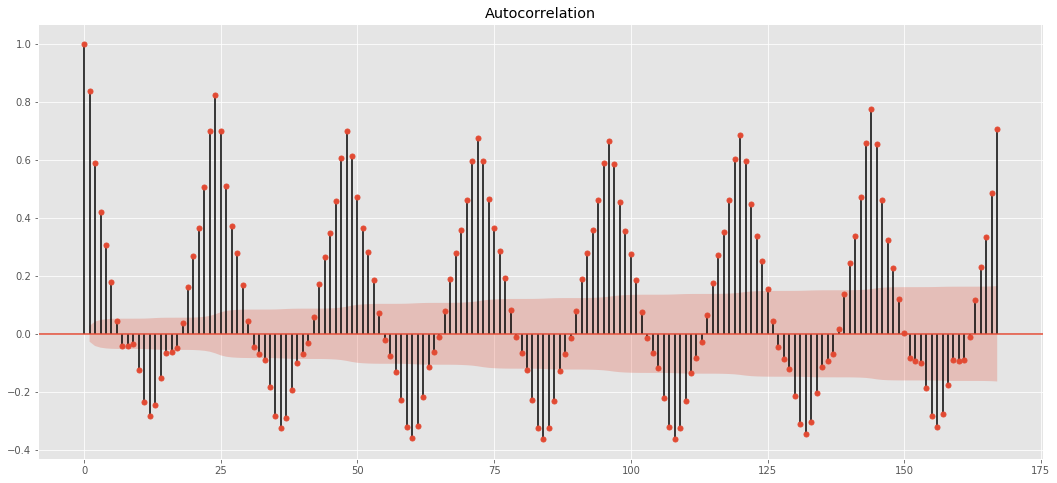

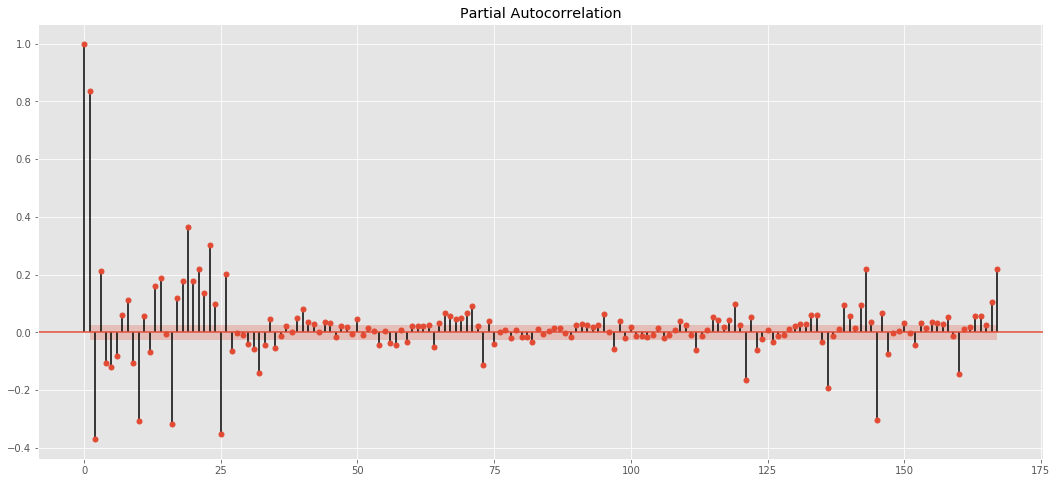

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
X = df_bixi_byhour
ax = plot_acf(X, lags = np.arange(24*7))
ax = plot_pacf(X, lags = np.arange(24*7), method='ywm')
plt.show

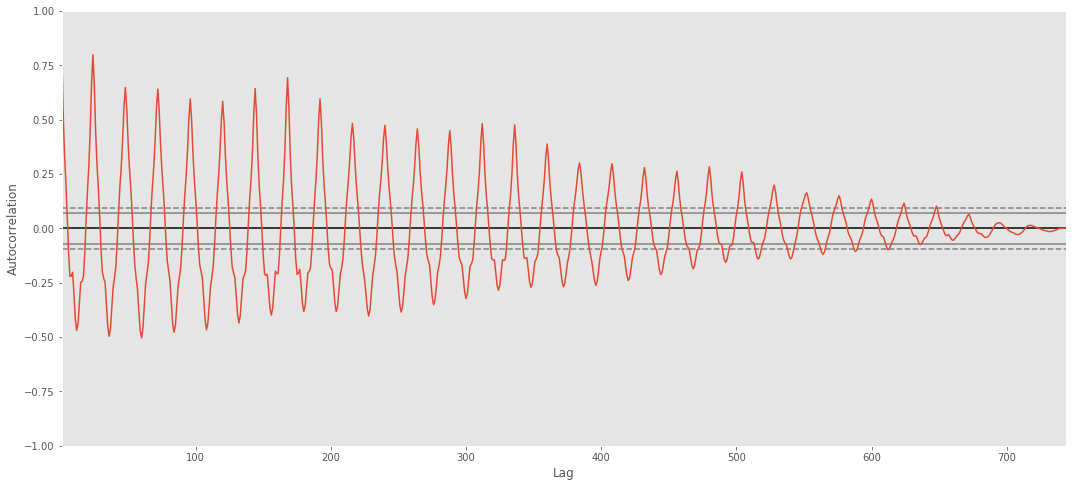

In [43]:
pd.plotting.autocorrelation_plot(df_bixi_byhour['07-2018'].dropna());

In [300]:
df.head(2)

# y = df['# Bixi rentals']
# X = df['temp']
# 'day_ind', 'temp','precip_hrly','is_weekend','day_ind'

ValueError: cannot reindex from a duplicate axis

In [299]:
comb = (1,0,1)
combs = (1,0,1,24)

import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(
    endog = y,
    exog = X,
    order=(1,0,1),
    seasonal_order=(1,1,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False)

output = mod.fit()
output.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

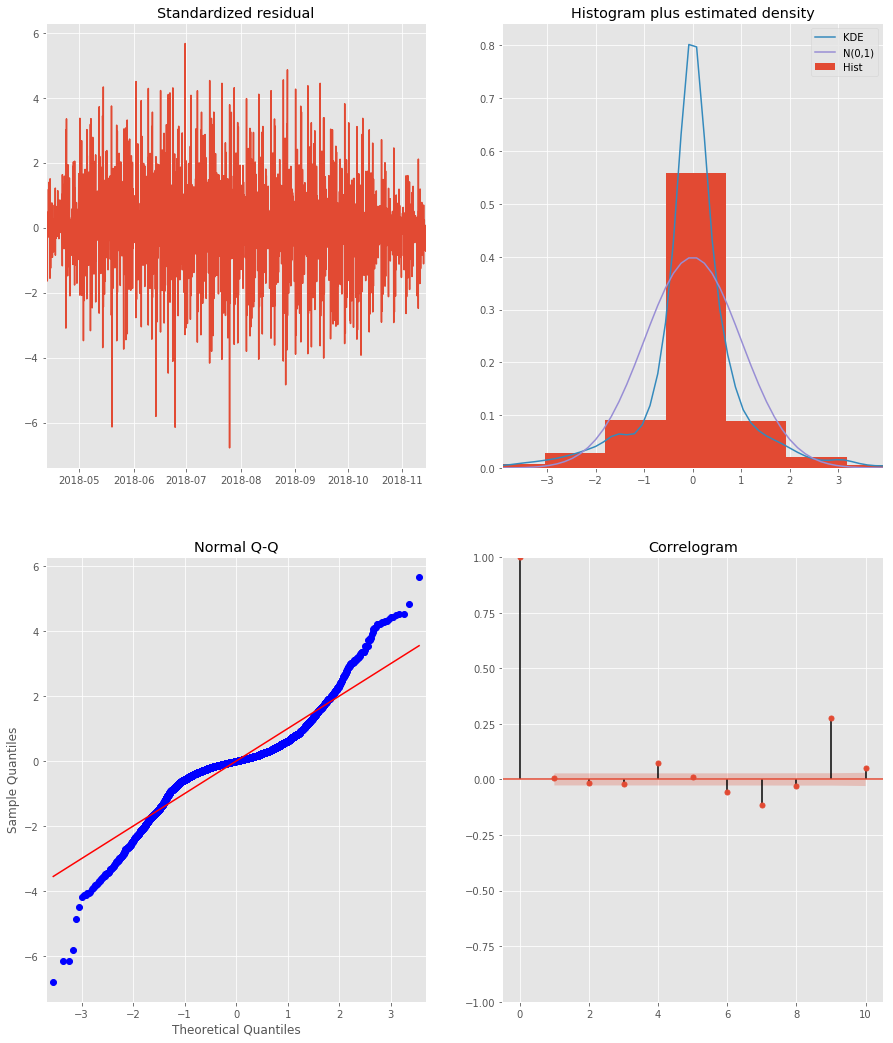

In [73]:
output.plot_diagnostics(figsize=(15, 18));

In [261]:
pred = output.get_prediction(start=pd.to_datetime('2018-11-01'), dynamic=False)
pred_conf = pred.conf_int()

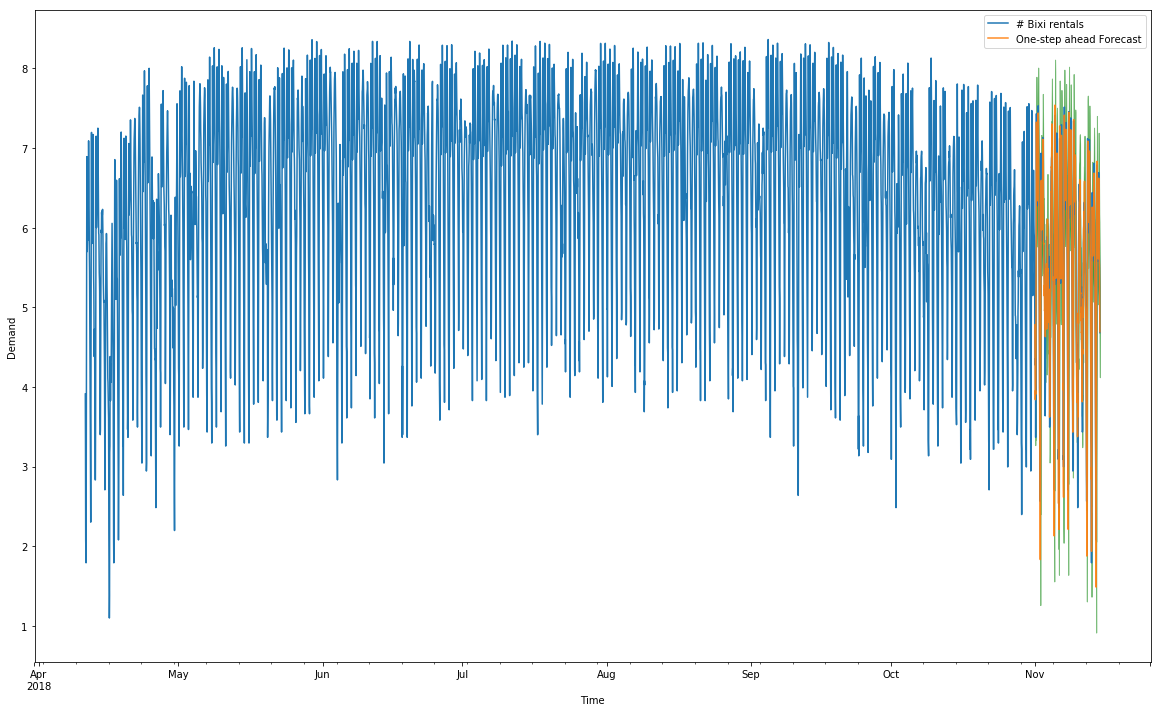

In [262]:
rcParams['figure.figsize'] = 20,12

#Plot observed values
ax = np.log(df_bixi_byhour['2018-04-11':]).plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Time')
ax.set_ylabel('Demand')
plt.legend()

plt.show()

In [7]:
# Get the Real and predicted values
forecast = pred.predicted_mean.values
real = df_bixi_byhour.values.flatten()

# Mean square error
mse = ((np.exp(forecast) - np.exp(real)) ** 2).mean()
print('The Mean Squared Error of forecast is {}'.format(mean_squared_error(forecast,real)))
print('R2 score is {}'.format(r2_score(forecast,real)))


NameError: name 'pred' is not defined

In [179]:
res = pd.DataFrame()
res['forecast'] = np.exp(forecast)
res['real'] = np.exp(real)
res['error'] = (res['forecast'] - res['real'])/res['real']

In [180]:
res.index = df_bixi_byhour['2018-06-01':].index

In [181]:
res.shape

(4008, 3)

In [65]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [69]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_bixi_byhour,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:90010.30981590616
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:84912.22626748444
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:79839.85268478494
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:78392.3624601929
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:79652.32784257238
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:78814.66674632057
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:79375.95098409447
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:77873.84246291725
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:84145.93105483353
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:79801.95587126305
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:75970.3658026981
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:74407.53088214541
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:75726.60045441857
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:74742.91491407508
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:75517.77004539545
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:73925.98946768232
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:79809.08479663322
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:76506.3434818718
ARIMA(0, 1, 0

In [178]:
# mod = sm.tsa.statespace.SARIMAX(df_bixi_byhour,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(1, 1, 0, 24),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results = mod.fit()
# print(results.summary().tables[1])

### FB Prophet

In [229]:
# !pip install pystan
# !conda install -y -c conda-forge fbprophet

In [263]:
from fbprophet import Prophet as proph

In [343]:
didi = df_bixi_byhour.reset_index().rename(columns = {'date_hour': 'ds', "# Bixi rentals": "y"})

In [ ]:
m = proph(yearly_seasonality=False, interval_width= 0.95, changepoint_prior_scale = 0.0001)

# change_prior_scale decreased to make the trend less flexible

m.add_seasonality(
    name='weekly',
    period=7*24,
    fourier_order = 4)

m.fit(didi)
future = m.make_future_dataframe(periods=24)
future.tail()

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.


In [361]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-04-11 00:00:00,495.798319,-576.914055,1494.077187
1,2018-04-11 01:00:00,370.326483,-704.902668,1444.113376
2,2018-04-11 02:00:00,166.748000,-824.503725,1317.761283
3,2018-04-11 03:00:00,-16.032313,-1102.764939,1152.022039
4,2018-04-11 04:00:00,-39.304505,-1055.137678,1108.330269


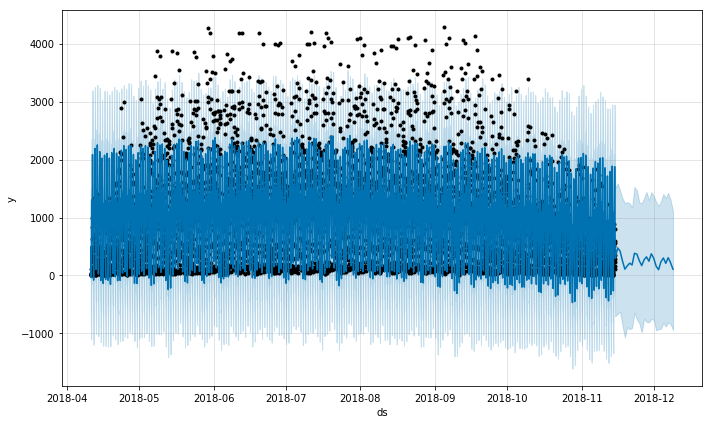

In [362]:
fig1 = m.plot(forecast)

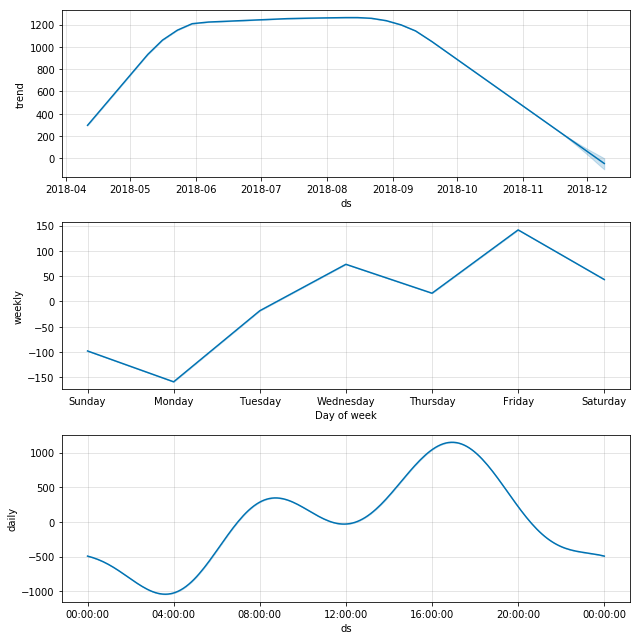

In [326]:
fig2 = m.plot_components(forecast)

In [ ]:
future = m.make_future_dataframe(periods=120, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)



## Algo options

#### Fast Fourier Transformation  (FFT algorithm) : 

- run FFT decomposition on input data
- decomposition into different sin functions and adding them gives original time series
- filter null amplitude or high frequency components (Noise because high frequency & irregularly)
- we have bunch of sinoid functions, keep the most significant
- recombine them & forecast
- https://www.youtube.com/watch?v=VYpAodcdFfA

#### Deep Learning - because of weather or event in the city that will hike up the demand